In [1]:
import os
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import networkx as nx

In [4]:


# Initialize Sentiment analyzer
analyzer = SentimentIntensityAnalyzer() 

def calculate_sentiment(text):
    if not text.strip():  # Check if empty after removing whitespace
        return 0  # Return 0 for empty tweets 
    score = analyzer.polarity_scores(text)['compound']
    return score


def process_data(zomato_path, dunzo_path):
    results = []
    for filename in os.listdir(zomato_path) + os.listdir(dunzo_path): 
        if filename.startswith('z_'):
            brand = 'zomato'
        elif filename.startswith('d_'):
            brand = 'dunzo'
        else:
            continue  

        # Extract date from filename (dd-mm-yyyy format)
        date_str = filename.split('_')[2] + "-" + filename.split('_')[1] + "-" + filename.split('_')[3].split('.')[0] 

        # Reformat date for sorting  (mm-dd-yyyy)
        mmddyyyy_date_str = date_str[3:5] + "-" + date_str[:2] + "-" + date_str[6:]

        filepath = os.path.join(zomato_path if brand == 'zomato' else dunzo_path, filename)
        df = pd.read_csv(filepath)

        # Calculate daily sentiment 
        daily_sentiment = df['tweet_text_element'].apply(calculate_sentiment).mean()
        print(daily_sentiment)
        # Find or create the matching date entry 
        existing_entry = next((item for item in results if item['day'] == mmddyyyy_date_str), None) 
        if existing_entry:
            existing_entry[f'{brand}_sentiment'] = daily_sentiment
        else:   
            results.append({
                'day': mmddyyyy_date_str,  
                f'{brand}_sentiment': daily_sentiment 
            })

    # Sort after processing all files 
    results.sort(key=lambda item: item['day'])  

    return pd.DataFrame(results)

zomato_path = 'Zomato'
dunzo_path = 'Dunzo'
df = process_data(zomato_path, dunzo_path)
df.to_csv('zomato_vs_dunzo_sentiment_analysis_results.csv', index=False, date_format='%m-%d-%Y')  # index=False to avoid an extra index column



0.1803193548387097
0.14891666666666667
0.58059375
0.03312857142857144
0.213875
0.22991999999999999
0.27700714285714284
0.23074800000000004
-0.2853
0.0
0.10775384615384617
0.10676060606060607
0.0
0.4700666666666667
0.11753571428571429
0.034676923076923084
0.2983875
0.004738461538461538
0.20674285714285714
0.29664999999999997
0.5443562500000001
0.22661428571428568
0.3355066666666667
0.2832909090909091
0.04870769230769229
0.04710769230769231
0.2099818181818182
0.5109750000000001
0.530705
0.3078166666666667
0.06924390243902438
0.2039111111111111
0.35300624999999997
0.4457916666666667
0.33247333333333334
0.577425
0.11747605633802817
0.059294117647058824
0.3773833333333334
-0.017606451612903234
0.2948916666666667
0.14997142857142862
-0.07950344827586206
-0.017617241379310342
0.269525
0.2958727272727273
0.3966375
0.027571428571428573
0.338890243902439
0.31518918918918915
0.44896
-0.36630625000000006
0.5423
-0.05135
0.0
nan
0.5605269230769232
0.2065875
-0.2154738095238096
0.4347919999999999
0.

In [28]:
def calculate_influence(df):
    # Normalize sentiment scores
    scaler = MinMaxScaler()
    df[['zomato_sentiment', 'dunzo_sentiment']] = scaler.fit_transform(df[['zomato_sentiment', 'dunzo_sentiment']])

    # Correlation-based influence
    correlation = np.corrcoef(df['zomato_sentiment'], df['dunzo_sentiment'])[0, 1]
    abs_correlation = abs(correlation)

    influence_zomato_on_dunzo = abs_correlation * 100 
    influence_dunzo_on_zomato = abs_correlation * 100 

    return influence_zomato_on_dunzo, influence_dunzo_on_zomato

# Load the data
df = pd.read_csv('zomato_vs_dunzo_sentiment_analysis_results.csv')
df["zomato_sentiment"]=df["zomato_sentiment"].fillna(df["zomato_sentiment"].mean())
df["dunzo_sentiment"]=df["dunzo_sentiment"].fillna(df["dunzo_sentiment"].mean())
# Calculate influences
influence_zomato_on_dunzo, influence_dunzo_on_zomato = calculate_influence(df)

print(f"Influence of zomato on dunzo: {influence_zomato_on_dunzo:.2f}%")
print(f"Influence of dunzo on zomato: {influence_dunzo_on_zomato:.2f}%")


Influence of zomato on dunzo: 14.70%
Influence of dunzo on zomato: 14.70%


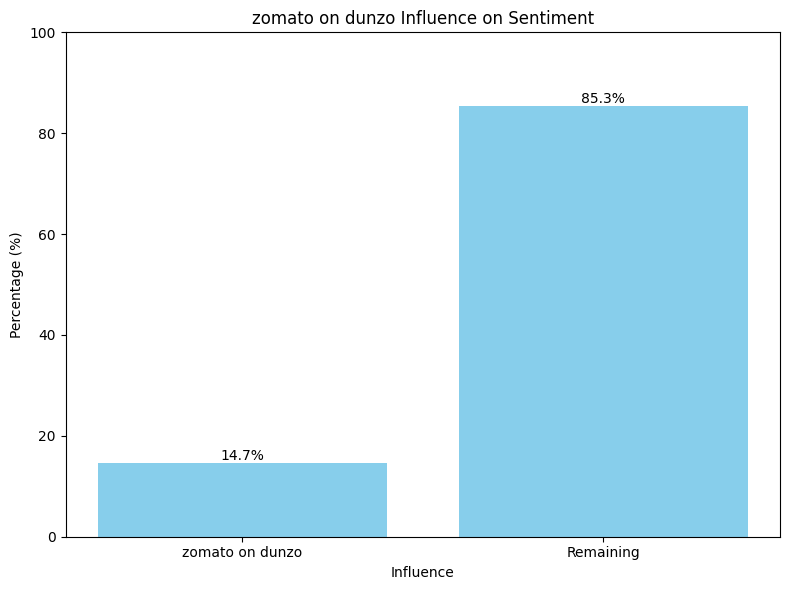

In [29]:

brand = "zomato on dunzo"  
influence_percentage = influence_zomato_on_dunzo

# Create data for the bar graph
data = {'Influence Score (%)': [influence_percentage, 100 - influence_percentage]}
df = pd.DataFrame(data, index=[brand, 'Remaining'])

# Constants for styling
SELECTED_COLOR = 'indianred'  

def on_click(event):
    # Clear previous selection (if any)
    for bar in bars:
        bar.set_color('skyblue')  # Or your original color

    # Highlight the clicked bar
    if event.inaxes == ax: 
        event.artist.set_color(SELECTED_COLOR)
        fig.canvas.draw()  # Redraw the canvas

# Create the bar graph
fig, ax = plt.subplots(figsize=(8, 6))  
bars = ax.bar(df.index, df['Influence Score (%)'], color='skyblue')
plt.xlabel('Influence')
plt.ylabel('Percentage (%)')
plt.title(f"{brand} Influence on Sentiment")
plt.ylim(0, 100) 

# Add percentage labels (optional)
for bar in bars:
    value = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2.0
    y = bar.get_y() + value  
    plt.text(x, y, f"{value:.1f}%", ha='center', va='bottom') 

fig.canvas.mpl_connect('button_press_event', on_click)
plt.tight_layout()
plt.show()


In [30]:
def process_data(zomato_path, dunzo_path):
    all_data = []
    for path, brand in [(zomato_path, 'zomato'), (dunzo_path, 'dunzo')]:
        for filename in os.listdir(path):
            if filename.startswith(brand.lower()[0] + '_'):  
                filepath = os.path.join(path, filename)
                df = pd.read_csv(filepath)
                df['brand'] = brand  
                all_data.append(df)

    combined_df = pd.concat(all_data)
    return combined_df

df = process_data(zomato_path, dunzo_path)
print(df.head)

<bound method NDFrame.head of                      username  \
0             Hindustan Times   
1                Bhavik Mehta   
2             Amrut nevarekar   
3                Sagar Paleja   
4            Katherine Pierce   
..                        ...   
19  Andie Dufrense (ATTORNEY)   
20                    Polaris   
21               Shyam Yuvraj   
22                  Kia India   
23                    okrrrrr   

                                   tweet_text_element   brand  
0   #DeepinderGoyal, co-founder and CEO of the onl...  zomato  
1   You may start with a Soup, but the end should ...  zomato  
2   You may start with a Soup, but the end should ...  zomato  
3   New Amex Plat Charge users, check your emails ...  zomato  
4   New Amex Plat Charge users, check your emails ...  zomato  
..                                                ...     ...  
19  Wow… there’s so much delusion here, I’m almost...   dunzo  
20  Dunzo Fernandez can only dream of delivering l...   dunzo

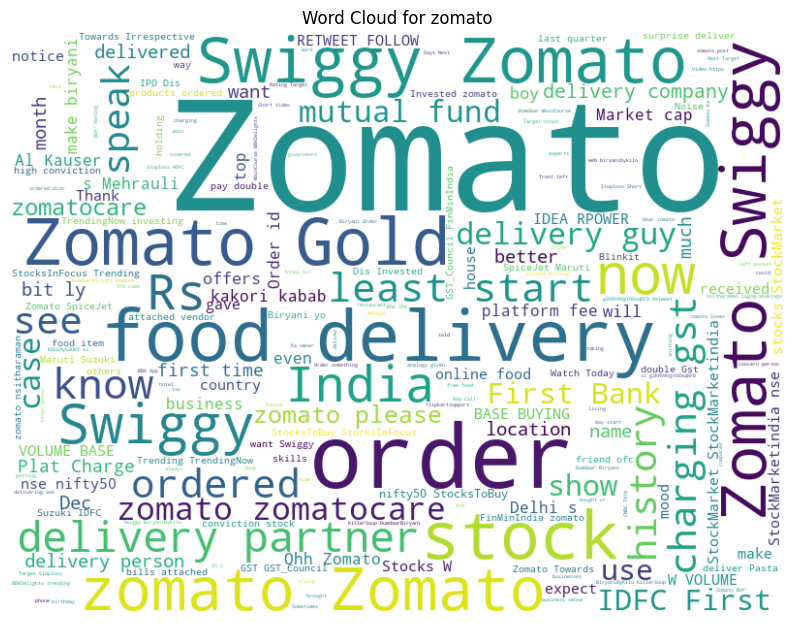

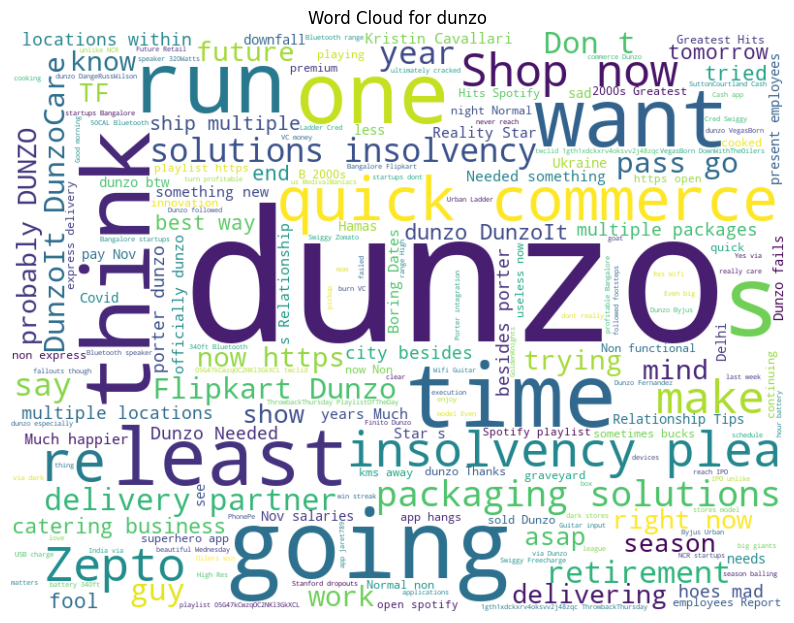

In [31]:


def generate_wordcloud(brand_data, brand_name):
    text = " ".join(tweet for tweet in brand_data['tweet_text_element'])
    wordcloud = WordCloud(background_color='white', width=800, height=600).generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {brand_name}")
    plt.show()

# Generate word clouds for each brand
for brand in df['brand'].unique():
    brand_data = df[df['brand'] == brand]
    generate_wordcloud(brand_data, brand)


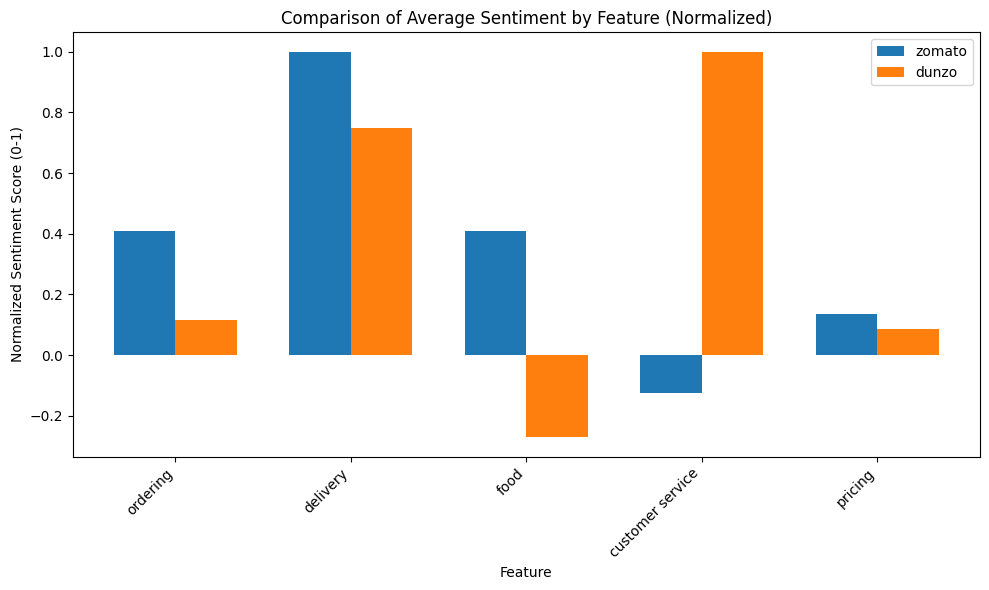

In [32]:
sentiment_scores = {}  # Initialize an empty dictionary to store sentiment scores

def calculate_feature_sentiment(tweet_text, feature_keywords):
    sentiment_score = 0  # Initialize
    if any(word in tweet_text for word in feature_keywords):
        sentiment_score = analyzer.polarity_scores(tweet_text)['compound']
    return sentiment_score

features = {
    "ordering": ["order", "ordering", "menu", "easy", "variety", "options"],
    "delivery": ["delivery", "time", "fast", "track", "tracking", "fee", "fees"],
    "food": ["food",  "quality", "taste", "delicious",  "portion"],
    "customer service": ["service", "support", "help", "response", "refund"],
    "pricing": ["price", "value", "expensive", "cheap", "discount", "promotion"] 
}


for brand in df['brand'].unique():
    for feature, keywords in features.items():
        feature_df = df[df['brand'] == brand].copy()  # Create a copy here
        feature_df[f"{feature}_sentiment"] = feature_df['tweet_text_element'].apply(calculate_feature_sentiment, args=(keywords,))

        avg_sentiment = feature_df[f"{feature}_sentiment"].fillna(0).mean()
        # print(f"{brand} - {feature} Average Sentiment: {avg_sentiment:.3f}")
        
        # Store the calculated sentiment score in the dictionary
        if brand not in sentiment_scores:
            sentiment_scores[brand] = {}
        sentiment_scores[brand][feature] = avg_sentiment

# Print the sentiment scores dictionary
# print(sentiment_scores)

sentiment_data = sentiment_scores

# Normalize sentiment scores (assuming values range from 0 to 1)
def normalize_sentiment(sentiment_dict):
    for brand, features in sentiment_dict.items():
        max_value = max(features.values())
        for feature, sentiment in features.items():
            sentiment_dict[brand][feature] = sentiment / max_value
    return sentiment_dict

sentiment_data = normalize_sentiment(sentiment_data.copy())  # Normalize on a copy

# Extract feature labels and sentiment scores for each brand
brands = list(sentiment_data.keys())
feature_labels = list(sentiment_data[brands[0]].keys())
zomato_sentiment = [sentiment_data["zomato"][feature] for feature in feature_labels]
dunzo_sentiment = [sentiment_data["dunzo"][feature] for feature in feature_labels]

# Create a bar chart
plt.figure(figsize=(10, 6))
x = range(len(feature_labels))
bar_width = 0.35
plt.bar(x, zomato_sentiment, bar_width, label='zomato')
plt.bar([p + bar_width for p in x], dunzo_sentiment, bar_width, label='dunzo')
plt.xlabel('Feature')
plt.ylabel('Normalized Sentiment Score (0-1)')
title = 'Comparison of Average Sentiment by Feature (Normalized)'
plt.title(title)
plt.xticks([p + bar_width / 2 for p in x], feature_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


Top Features for zomato: ['ordering', 'delivery', 'pricing']
Top Features for dunzo: ['ordering', 'delivery', 'pricing']


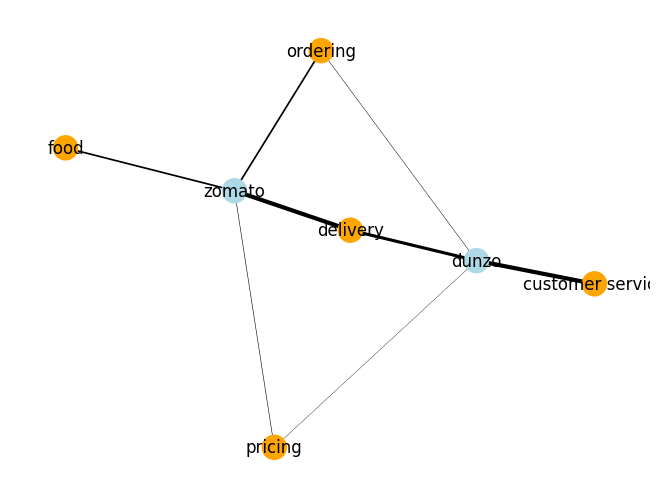

In [33]:
G = nx.Graph()

# Add brands and features as nodes
brands = sentiment_scores.keys()
features = list(sentiment_scores["zomato"].keys())  # Assuming features are the same across brands

for brand in brands:
    G.add_node(brand, type="brand")  

for feature in features:
    G.add_node(feature, type="feature") 

sentiment_threshold = 0.01  # Example threshold

for brand, feature_data in sentiment_scores.items():
    for feature, sentiment in feature_data.items():
        if sentiment >= sentiment_threshold: 
            G.add_edge(brand, feature, weight=sentiment)

# Node Importance
degree_centrality = nx.degree_centrality(G)  

for brand in brands:
    brand_features = [n for n in G.neighbors(brand)]  # Features connected to a brand
    top_features = sorted(brand_features, key=lambda x: degree_centrality[x], reverse=True)[:3]
    print(f"Top Features for {brand}: {top_features}")
    
# Customize visualization 
node_colors = ['lightblue' if G.nodes[n]['type'] == 'brand' else 'orange' for n in G.nodes()]
edge_widths = [d['weight'] * 3 for (_, _, d) in G.edges(data=True)]  # Adjust for visual clarity
pos = nx.spring_layout(G)  # You can experiment with different layouts

nx.draw(G, pos, with_labels=True, node_color=node_colors, width=edge_widths)
plt.show()

<Figure size 1200x600 with 0 Axes>

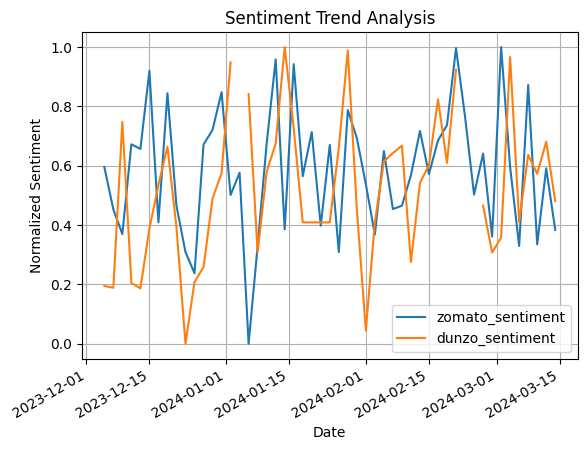

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the data file is named 'zomato_vs_dunzo_sentiment_analysis_results.csv'
data_path = 'zomato_vs_dunzo_sentiment_analysis_results.csv'

try:
  # Read the data from the CSV file
  df = pd.read_csv(data_path)

  # Check if 'day', 'zomato_sentiment', and 'dunzo_sentiment' columns exist
  if all(col in df.columns for col in ['day', 'zomato_sentiment', 'dunzo_sentiment']):
    # Convert date strings to datetime format
    df['day'] = pd.to_datetime(df['day'], format='%d-%m-%Y')

    # Normalize sentiment scores (0-1 range)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[['zomato_sentiment', 'dunzo_sentiment']] = scaler.fit_transform(df[['zomato_sentiment', 'dunzo_sentiment']])

    # Plot sentiment trends (corrected)
    plt.figure(figsize=(12, 6))
    df.plot(x='day', y=['zomato_sentiment', 'dunzo_sentiment']) 
    plt.xlabel('Date')
    plt.ylabel('Normalized Sentiment')
    plt.title('Sentiment Trend Analysis')
    plt.grid(True)
    plt.legend()
    plt.show()
  else:
    print(f"Error: The data file '{data_path}' is missing required columns.")

except FileNotFoundError:
  print(f"Error: The data file '{data_path}' could not be found.")
